# Introduction to Flow Models

### Problem Statement
Suppose you have a high-dimensional dataset whose structure you are aiming to understand. For instance, you might be trying to interpret image data capturing people's faces or sound-data collecting voice recordings. If you are working with multi-layered artificial neural networks, you might have a latent representation that must capture something intermediate to the stimulus modality and abstract semantics. All these examples have in common that the data is a collection of instances and each such instance is defined as a point in a high-dimensional space. The points form a cloud (also known as manifold) that likely has a complicated shape. Yet, some regions of the point-cloud group certain instances and this grouping corresponds to a human-understandable concept or factor. 


In the case of facial images, this could be the size of a nose, the color of the eyes or whether someone is wearing a hat:

<img src="https://github.com/TimHenry1995/gyoza/blob/main/docs/images/Images%20of%20Face%20Parts.png?raw=true" width="600"/>

For image references click [left](https://cdn.mos.cms.futurecdn.net/5HYdrDsenbowySwd8WnARf-1000-80.jpg), [middle](https://lh5.googleusercontent.com/proxy/eFWeUzmakVUxfVZN2UPILcGjEV3x-WXLW-Bof9ReHUxYSxby4Mbu8kIi_WKZ_T14ZboJmXR2NRWLL17t3lrEyFPxNhhdlwFLqX9mj8ODz0zPinjhDmEqWOZcYukFbf2WQ-h-k8uGBnvwIfhz0iUnBWspIA), [right](https://www.monsoon.co.uk/dw/image/v2/BDLV_PRD/on/demandware.static/-/Sites-monsoon-master-catalog/default/dwc17cd212/images/large/21_20018770015_1.jpg?sw=663&sh=848&sm=cut)

For the voice-recordings, this could be whether it is a male or female voice or whether an adult or a child is speaking. 

<img src="https://github.com/TimHenry1995/gyoza/blob/main/docs/images/Images%20of%20Mouths.png?raw=true" alt="images of mouths" width="600"/>

For image reference, click [left](https://www.shutterstock.com/image-photo/closeup-male-mouth-healthy-smile-260nw-1564211686.jpg), [middle](https://img.pixers.pics/pho_wat(s3:700/FO/41/73/45/67/700_FO41734567_dddf4884ecfea4f8a5fcf19114d4c28c.jpg,700,467,cms:2018/10/5bd1b6b8d04b8_220x50-watermark.png,over,480,417,jpg)/stickers-smiling-woman-mouth-with-great-teeth-over-white-background.jpg.jpg"), [right](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSvids2TtwliedPRuR9nYemP25-HtlFL67Orw&s")

To better understand the structure of a manifold, we thus need to project it to a lower dimensional space for which it is easier to reason about. While linear projection methods such as principal component analysis are widely used, they only allow to reshape a manifold by moving, shearing, flipping or rotating it. Apart from that, it is biased towards the dominant axes of variance, while these might not always be the factor of interest to you. More advanced non-linear projection methods like t-distributed stochastic neighborhood embeddings (t-SNE), uniform manifold approximations and projections (UMAPs) or artificial neural networks (ANNs) can morph space by squeezing some parts more than others. However, t-SNE and UMAP are not invertible and ANNs would need a mirrored version of themselves to approximate their own inverse. This requires more model parameters, training resources and is inaccurate.

In this interactive notebook, we will learn about supervised disentangling flow models that can compute a non-linear mapping from a high-dimensional space to a low-dimensional one and thus allow to test for and visualize certain structures thought to underly the given high-dimensional manifold. Due to their trivial invertibility, these flow models allow to map systematic changes made in the disentangled space back onto the original space. 

While the ultimate goal is, of course, to work with high-dimensional manifolds like yours, this notebook aims to equip you with an intuition for the mechanisms underlying this disentanglement technique. In order to establish this intuition, the notebook will use simple 2-dimensionsional case studies to test the models' abilities to deal with rotations, non-linear stretching or discontinuities. For instance, the swirl that is shown in the below image on the left. For this manifold, one could argue that there is only one meaningful factor and that is a point's position along the swirl. The goal would thus be to map from the 2-dimensional space to a 1-dimensional space that captures this factor. For the first case studies, simple models will be demonstrated while later case studies use more advanced models. The results are evaluated quantitatvely and discussed. Due to the interactive nature of this notebook, it is possible for the reader to  change experimental configurations and thus verify the observations made here. In order to build the flow models, the software package [gyoza](https://pypi.org/project/gyoza/) will be used. Readers who are unfamiliar with this toolbox can read its [documentation](https://gyoza.readthedocs.io/en/latest/index.html) alongside this tutorial. For readers who intend to embed gyoza's flow models into their own processing pipelibe, further tutorials can be found on the project's [GitHub](https://github.com/TimHenry1995/gyoza) page.

<img src="https://github.com/TimHenry1995/gyoza/blob/main/docs/images/Manifold%20Disentanglement%20Cartoon.png?raw=true" alt="drawing" width="600"/>


### Background
Flow models are invertible artificial neural networks that can be used for various tasks including regression, probability densitiy estimation and latent factor disentanglement. Similar to regular neural networks, flow networks can be used for classification, as has been shown for instance for optical character recognition [[4](#References)]. Yet, the real contribuiton lies in the efficient invertibility. As first demonstrated by Rezende and Shakir in the year 2015 [[1](#References)], it is possible to feed a sample from a normal distribution through an inverse flow model to obtain a sample from an arbitrary desired data distribution. It thus allows, for instance, to generate photorealistic pictures of human faces [[2](#References)], animals [[2,3,4](#References)] or furniture [[3](#References)]. Apart from that, flow models compare to principal component analysis, or independent component analysis in that they can be used to disentangle latent factors [[4,5](#References)]. Esser, Rombach and Ommer demonstrated in the year 2020 how complicated manifolds in the latent space of regular artificial neural networks can be decomposed into comprehensive factors. They showed how traversal along those factors corresponds to changes in e.g. a person's hairstyle, smile or gender. Similar work has been done by Liu and colleagues in 2022 on medical images of the heart and brain [[5](#References)]. Flow models are still in their infancy and further experiments are needed to better understand their inner workings. 

### Competences Acquired In This Tutorial 
In this tutorial, the basic modelling cyle will be demonstrated with the help of the flow model package [gyoza](https://gyoza.readthedocs.io/en/latest/). Upon completion, the reader will be able to 
1. explain the basic properties of flow models
2. build sequential flow models with various layers
3. calibrate a model with synthetic data
4. save and load it for distribution 
5. use that model for inference

![Image](https://github.com/TimHenry1995/gyoza/blob/develop/docs/images/Modelling%20Cycle.png?raw=true)

### Gyoza Documentation
At the heart of the gyoza package lays the *flow_layers* module which defines among others, normalization, reflection and coupling layers. The coupling layers rely on standard neural networks which can be constructued manually using [keras](https://keras.io). The *standard_layers* module also offers some keras models for this purpose. Coupling layers also rely on permutation layers (*flow_layer* module) and their corresponding masks (*masks* module). It is recommended to open the [documentation](https://gyoza.readthedocs.io/en/latest/) now in a web browser and read it side-by-side with this tutorial. The corresponding pages will be highlighted in the following sections. 

### Gyoza Installation
The gyoza package is built on top of [tensorflow](https://www.tensorflow.org) and has been developed with a minium number of required packages to simplify installation. It is distributed via the python package index and can thus be installed via pip. In case of installation problems, the reader is invited to contact the developer Tim Dick via [GitHub](https://github.com/TimHenry1995/gyoza/tree/main).

In [2]:
#%pip install gyoza

In [3]:
from gyoza.modelling import flow_layers as mfl, masks as mm, standard_layers as msl
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, os

## Model Building
The model bulding routine involves constructing layers and composing them into more complicated models. The approach is thus similar to that of [tensorflow](https://www.tensorflow.org) and [keras](https://keras.io). For readers unfamiliar with the different types of flow layers, it is recommended to review relevant [literature](#references). In the next code snippets, example data is structured as in image processing and fed through different layers. 

An important aspect of flow layers is that the dimensionality (total number of dimensions spread across all axes) does not change. This is different from regular artificial neural networks which allow for projections from high-dimensional input spaces to low dimensional outputs spaces, e.g. in image classification. A standard approach when modelling with gyoza is to specify along which axes (and corresponding input shape along those axes) the transformations shall be applied. One could for instance limit transformation to spatial, temporal or channel axes. 

Another important aspect of flow layers is their ability to compute their own Jacobian determinant and to provide its own inverse. This is useful for density estimation of probability distributions when working with the change of variables formula during sampling as demonstrated by Dinh, Sohl-Dickstein and Bengio [[3](#references)]. It is also useful for latent factor disentanglement as shown by Esser, Rombach and Ommer [[4](#references)]. *Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for FlowLayer invert() and compute_jacobian_determinant().*

In [4]:
# Configuration
instance_count = 100; width = 4; height = 4; channel_count = 3
shape = [instance_count, width, height, channel_count]
dimensionality = np.prod(shape[1:])
X = np.random.normal(loc=3, scale=5, size=shape)
Y = X**2 + 3*X - 1

A complete model can be constructucted by arranging the layers in a sequence. The flow_layers module provides a sequential layer which requires a sequence of flow layers as input.

**IMPORTANT:** It is recommended to neither use the Sequential model from keras nor to build custom models with multiple pathways in tensorflow. This is because every gyoza flow layer is able to provide a Jacobian determinant for its forward operation and to invert itself. This functionality would be lost within a keras Sequential model. Within a multi-pathway tensorflow model it is not obvious how to maintain these properties for the overall model and should thus be done by advanced users who have the relevant mathematical background at their disposal.

In [12]:
# Create model
def create_model(width: int, height: int, channel_count: int):
    activation_normalization = mfl.ActivationNormalization(axes=[1,2], shape=[width, height]) 
    reflection = mfl.Reflection(axes=[3], shape=[channel_count], reflection_count=2)
    checker_board_mask = mm.CheckerBoard(axes=[1,2,3], shape=[width,height, channel_count])
    compute_coupling_parameters = tf.keras.layers.Conv2D(filters=channel_count, kernel_size=(3,3), padding='same')
    coupling = mfl.AdditiveCoupling(axes=[1,2,3], shape=[width, height, channel_count], compute_coupling_parameters=compute_coupling_parameters, mask=checker_board_mask)

    return mfl.FlowModel([activation_normalization, reflection, coupling])

model = create_model(width=width, height=height, channel_count=channel_count)

# Print
print("The input to model has shape (instance count, width, height, channel count): ", X.shape)
Y_hat = model(X)
print("The output of model has shape (instance count, width, height, channel count): ", Y_hat.shape)

The input to model has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
The output of model has shape (instance count, width, height, channel count):  (100, 4, 4, 3)


## Model Calibration

Gyoza flow models can be calibrated by means of the fit() method. This method can be used on the whole data directly when X,Y and sample_size are provided. Alternatively, an iterator can be provided, for instance if the data is so large that batches need to be loaded from disk one at a time. **Important:** Similar to [keras](https://keras.io/api/models/model_training_apis/), the network needs to be compiled with an [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) and a [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses) before fitting. For some flow models, such as the SupervisedFactorNetwork, gyoza offers particular losses. *Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for Flowlayer.fit(), SupervisedFactorNetwork, SupervisedFactorLoss.*

Epoch 1/10 - Loss: 4333.1113 - StdDev: 131.1659

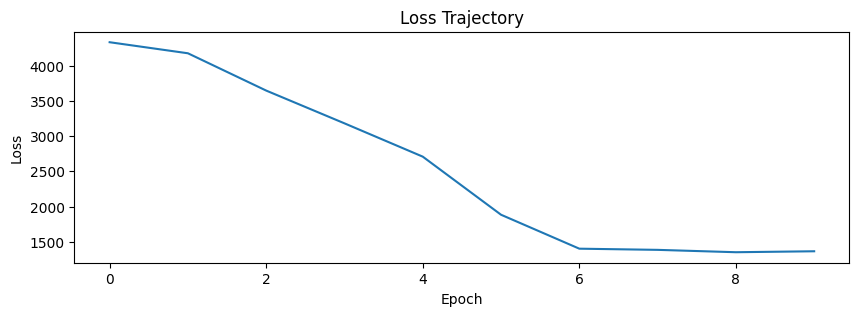

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.MeanSquaredError())
epoch_loss_means, epoch_loss_standard_deviations = model.fit(epoch_count=10, batch_count=15, X=X, Y=Y, batch_size=32)
plt.figure(figsize=(10,3)); plt.title('Loss Trajectory'); plt.plot(epoch_loss_means); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.show()

## Saving and Loading

In order to store and distribute a model in gyoza, one needs to save its trainable parameters. **Important:** Since not all flow_layers are serializable by the regular [tensorflow](https://www.tensorflow.org/tutorials/keras/save_and_load) protocol it is only possible to save the model parameters but not the entire model. It is thus recommended to wrap the code for model creation in a function that can be called to construct a new model with the same architecture. That new model can then be loaded with the weights that were saved previously. 

In [14]:
# Save existing model
path = "example_model.weights.h5"
model.save_weights(path)

# Initialize a new instance of same architecture
new_model = create_model(width=width, height=height, channel_count=channel_count)
new_model.build(input_shape=X.shape) # Ensures model weights are initialized

# Load weights
new_model.load_weights(path); 
os.remove(path) # The file is no longer needed and deleted to prevent clutter

# Compare
print("The saved and the loaded model weights produce a prediction difference equal to", tf.reduce_sum((model(X)-new_model(X))**2).numpy())

The saved and the loaded model weights produce a prediction difference equal to 0.0


## Model Inference

After the model is distributed, it can be used by other developers or data scientists for inference. The receiver can do so by calling the model on an input of appropriate shape. 

In [15]:
print("The input to the loaded model has shape (instance count, width, height, channel count): ", X.shape)
Y_hat = new_model(X)
print("The output of loaded model has shape (instance count, width, height, channel count): ", Y_hat.shape)

The input to the loaded model has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
The output of loaded model has shape (instance count, width, height, channel count):  (100, 4, 4, 3)


## Next Steps
This was a tutorial on how to use the gyoza modelling framework for flow layers. There are actual experiments performed with gyoza on [GitHub](https://github.com/TimHenry1995/gyoza/tree/main).

## References

[1] ["Variational Inference with Normalizing Flows" by Danilo Jimenez Rezende and Shakir Mohamed](https://arxiv.org/abs/1505.05770)

[2] ["Glow: Generative Flow with Invertible 1×1 Convolutions" by Diederik P. Kingma, Prafulla Dhariwal](https://arxiv.org/abs/1807.03039)

[3] ["DENSITY ESTIMATION USING REAL NVP" by Laurent Dinh, Jascha Sohl-Dickstein, Samy Bengio](https://arxiv.org/abs/1605.08803)

[4] ["A Disentangling Invertible Interpretation Network for Explaining Latent Representations" by Patrick Esser, Robin Rombach, Björn Ommer](https://arxiv.org/abs/2004.13166)

[5] ["Learning disentangled representations in the imaging domain" by Xiao Liu, Pedro Sanchez, Spyridon Thermos, Alison Q. O'Neil, Sotirios A. Tsaftaris](https://arxiv.org/abs/2108.12043)